<a href="https://colab.research.google.com/github/MutantLeech/CRE-Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Giant pre-preprocessing cell
# I fully expect this to take like a full hour, this has literally 47,000,000 lines and it's gotta go line by line (Update: 7m15s. python do be data processing)
import regex as re
import numpy as np
import chess

# Pack these collections of games into dictionaries for easier processing
def dict_pack(game):
    # These tags are in the form [TagName "TagValue"]
    tag_regex = r"\[(.*?) \"(.*?)\"\]"
    said_dict = {}

    for line in game:
        possible_match = re.match(tag_regex, line)
        if possible_match:
            said_dict[possible_match.group(1)] = possible_match.group(2)
        elif line != "\n":
            said_dict["Moves"] = line

    return said_dict

# Clean up move text so it's only the moves
def clean_move_text(text):
    # Four-step process
    # Step 1: Remove those markers for the move count
    cleaned_text = re.sub(r"\d+\.+ ", "", text)
    # Step 2: Remove any and all comments
    cleaned_text = re.sub(r"\{.*?\}", "", cleaned_text)
    # Step 3: Remove any more stragglers
    cleaned_text = re.sub(r"[^a-hnpqrxBKNOPQR0-8-+#\s]", "", cleaned_text)
    # Step 4: Clean up any extraneous spaces
    cleaned_text = re.sub(" +", " ", cleaned_text)

    return cleaned_text[:-1] # Snip the newline off the back

# Read in one game from the given file
def read_in_game(file) -> dict:
    lines = []
    skip_this_blank = True
    
    while True:
        current_line = file.readline()

        if not current_line:
            return None

        if current_line == "\n":
            if skip_this_blank:
                skip_this_blank = False
                continue
            else:
                break
        
        lines.append(current_line)

    lines[-1] = clean_move_text(lines[-1])
    return dict_pack(lines)

# We only want certain kinds of games for this task
def accept_or_reject(game_dict: dict):
    # Criteria for acceptance
    # 1: Not some random chess variant (i.e. regular chess)
    if "Variant" in game_dict:
        return False
    # 2: Ended normally
    if game_dict["Termination"] != "Normal":
        # print("abnormal termination: " + game_dict["Termination"])
        return False
    # 3: Has a normal result (including draws)
    if game_dict["Result"] not in ["1-0", "0-1", "1/2-1/2"]:
        # print("abnormal result: " + game_dict["Result"])
        return False
    # Has the ELO ratings we're looking for
    if not ("WhiteElo" in game_dict and "BlackElo" in game_dict):
        # print("missing ELO rating(s)")
        return False
    else:
        # Does have ELO ratings, but...
        # Make sure the ELO ratings are normal (Some are just "?")
        try:
            white_int = int(game_dict["WhiteElo"])
            black_int = int(game_dict["BlackElo"])
        except ValueError:
            # print("invalid ELO rating(s)")
            return False

    # Passes all those checks, so we're good
    # print("check")
    return True

# Remove all unneccesary keys from the dictionary
# NOTE: Mutates given dictionary!
def condense_dict(game_dict: dict):
    ACCEPTED_TAGS = ["WhiteElo", "BlackElo", "Result", "Moves"]

    for tag in list(game_dict.keys()):
        if tag not in ACCEPTED_TAGS:
            del game_dict[tag]

# Return given data packing
# Alter as required
def clean_data(game_dict: dict):
    white_rating = int(game_dict["WhiteElo"])
    game_moves_split = game_dict["Moves"].split(" ")
    move_length = (len(game_moves_split) - 1) / 2 # Count of half-moves, minus one to remove result, divided by 2
    result = ["0-1", "1/2-1/2", "1-0"].index(game_dict["Result"]) / 2 # returns 0, 0.5, or 1

    return [white_rating, move_length, result]

# Convert from PGN to UCI-style moves
def to_uci(moves):
    pgn_moves = moves.split()[:-1] # Strip the result off the end
    uci_moves = []
    board = chess.Board()

    for move in pgn_moves:
        uci_moves.append(board.push_san(move).uci())
    
    return " ".join(uci_moves)


# Okay, now for the actual file processing
# Don't worry, .pgn files are just plaintext files, just with a special extension
ORIGINAL_DATA_FILE = r"lichess_db_standard_rated_2015-08.pgn" # If you've got another file, you can replace this
CONDENSED_DATA_FILE = f"{ORIGINAL_DATA_FILE[:-4]}_condensed.pgn"
CONDENSED_UCI_DATA_FILE = f"{ORIGINAL_DATA_FILE[:-4]}_condensed_uci.pgn"
CLEANED_DATA_FILE = f"{ORIGINAL_DATA_FILE[:-4]}_as_data.txt"

# OPTIONS
GAME_LIMIT = 50 # I want to test this out, so this means that only this many games get parsed
DOUBLE_GAMES = False # If true, record each game twice, from both the white and black perspective
CONDENSE = True # Condense data into shorter versions of each accepted game
CLEAN = True # Convert data into its condensed format

# Frankenstein these together so we don't have to read all the lines in twice
if CLEAN and CONDENSE:
    with open("datafiles/" + ORIGINAL_DATA_FILE, "r") as FILE, \
        open("datafiles/" + CONDENSED_DATA_FILE, "w") as CONDENSED_FILE, \
        open("datafiles/" + CONDENSED_UCI_DATA_FILE, "w") as CONDENSED_UCI_FILE, \
        open("datafiles/" + CLEANED_DATA_FILE, "w") as CLEANED_FILE:
            i = 0
            while True:
                game_dict = read_in_game(FILE)

                if not game_dict:
                    break

                if accept_or_reject(game_dict):
                    condense_dict(game_dict)
                    for key, value in game_dict.items():
                        if key == "Moves":
                            CONDENSED_FILE.write(value)
                            CONDENSED_UCI_FILE.write(to_uci(value))
                            CONDENSED_FILE.write("\n\n")
                            CONDENSED_UCI_FILE.write("\n\n")
                        else:
                            CONDENSED_FILE.write(f"[{key} \"{value}\"]\n")
                            CONDENSED_UCI_FILE.write(f"[{key} \"{value}\"]\n")

                    game_data = clean_data(game_dict)
                    CLEANED_FILE.write(str(game_data))
                    CLEANED_FILE.write("\n")

                    if DOUBLE_GAMES:
                        game_data[0] = int(game_dict["BlackElo"])
                        game_data[2] = 1 - game_data[2]
                        CLEANED_FILE.write(str(game_data)) # 1 - result gets the opposite result for black (or 0.5 again for a tie)
                        CLEANED_FILE.write("\n")

                    i += 1
                    # if i > GAME_LIMIT: break

            CLEAN = False
            CONDENSE = False # Set these to false to cut the cell early

if CONDENSE:
    with open("datafiles/" + ORIGINAL_DATA_FILE, "r") as FILE, \
    open("datafiles/" + CONDENSED_DATA_FILE, "w") as NEW_FILE, \
    open("datafiles/" + CONDENSED_UCI_DATA_FILE, "w") as NEW_UCI_FILE:
        i = 0
        while True:
            game_dict = read_in_game(FILE)

            if not game_dict:
                break

            if accept_or_reject(game_dict):
                condense_dict(game_dict)
                for key, value in game_dict.items():
                    if key == "Moves":
                        NEW_FILE.write(value)
                        NEW_UCI_FILE.write(to_uci(value))
                        NEW_FILE.write("\n\n")
                        NEW_UCI_FILE.write("\n\n")
                    else:
                        NEW_FILE.write(f"[{key} \"{value}\"]\n")
                        NEW_UCI_FILE.write(f"[{key} \"{value}\"]\n")

                i += 1
                # if i > GAME_LIMIT: break

if CLEAN:
    with open("datafiles/" + ORIGINAL_DATA_FILE, "r") as FILE, open("datafiles/" + CLEANED_DATA_FILE, "w") as NEW_FILE:
        i = 0
        while True:
            game_dict = read_in_game(FILE)

            if not game_dict:
                break

            if accept_or_reject(game_dict):
                game_data = clean_data(game_dict)

                NEW_FILE.write(str(game_data))
                NEW_FILE.write("\n")

                if DOUBLE_GAMES:
                    game_data[0] = int(game_dict["BlackElo"])
                    game_data[2] = 1 - game_data[2]
                    NEW_FILE.write(str(game_data)) # 1 - result gets the opposite result for black (or 0.5 again for a tie)
                    NEW_FILE.write("\n")

                i += 1
                # if i > GAME_LIMIT: break

In [ ]:
# Load all that data
def load_chess_data(file_path):
    chess_data = []

    with (open(file_path)) as FILE:
        for line in FILE:
            details = (line[1:-2]).split(", ") # -2: Have to account for the \n character
            details = [float(item) for item in details]
            chess_data.append(details)
    return chess_data

USE_THIS_FILE = "lichess_db_standard_rated_2015-08_as_data.txt" # Specify a different file name here, or leave blank
LOAD_THIS_DATA = "datafiles/" + (USE_THIS_FILE if len(USE_THIS_FILE) > 4 else CLEANED_DATA_FILE) # >4 means has more than an extension

chess_data = np.array(load_chess_data(LOAD_THIS_DATA))

700s
	Games played: 211
	Game Record [W/L/D]: [20 / 186 / 5]
	Win Percentage: 9.48%
800s
	Games played: 1572
	Game Record [W/L/D]: [288 / 1232 / 52]
	Win Percentage: 18.32%
900s
	Games played: 6405
	Game Record [W/L/D]: [1498 / 4701 / 206]
	Win Percentage: 23.39%
1000s
	Games played: 18784
	Game Record [W/L/D]: [5443 / 12723 / 618]
	Win Percentage: 28.98%
1100s
	Games played: 47315
	Game Record [W/L/D]: [16517 / 29256 / 1542]
	Win Percentage: 34.91%
1200s
	Games played: 92605
	Game Record [W/L/D]: [37170 / 52419 / 3016]
	Win Percentage: 40.14%
1300s
	Games played: 153005
	Game Record [W/L/D]: [65340 / 82210 / 5455]
	Win Percentage: 42.70%
1400s
	Games played: 214641
	Game Record [W/L/D]: [98248 / 108425 / 7968]
	Win Percentage: 45.77%
1500s
	Games played: 275195
	Game Record [W/L/D]: [132103 / 132343 / 10749]
	Win Percentage: 48.00%
1600s
	Games played: 271733
	Game Record [W/L/D]: [138195 / 122188 / 11350]
	Win Percentage: 50.86%
1700s
	Games played: 236936
	Game Record [W/L/D]: [1271

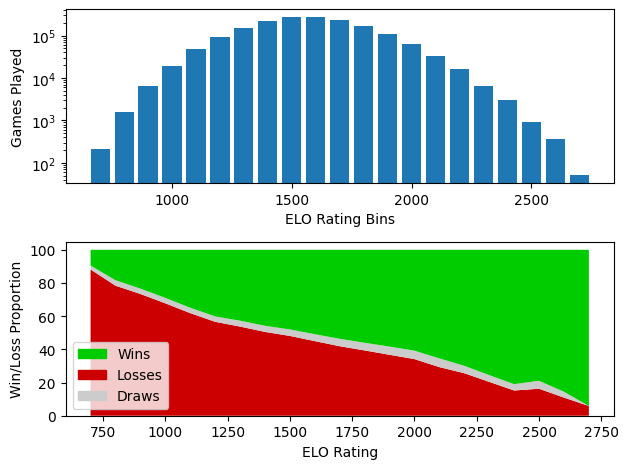

In [ ]:
# Additional statistics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from collections import Counter

elo_bounds = np.array([np.min(chess_data[:, 0]), np.max(chess_data[:, 0])])
elo_bounds = np.trunc(elo_bounds / 100) * 100
elo_bounds = [int(x) for x in elo_bounds]

data_range = np.arange(elo_bounds[0], elo_bounds[1] + 1, 100)

counters = Counter()
binned_statistics = {}
records_in_order = []

for game in chess_data:
    elo_bin = int(np.trunc(game[0] / 100)) * 100
    counters[elo_bin] += 1

    if elo_bin not in binned_statistics:
        binned_statistics[elo_bin] = np.array([0, 0, 0, 0])
    
    binned_statistics[elo_bin][int(game[2] * 2)] += 1  
    binned_statistics[elo_bin][3] += game[2]

for i in data_range:
    if i in binned_statistics and i in counters:
        record = [str(item) for item in binned_statistics[i][[2, 0, 1]]]
        record = " / ".join(record)
        record = f"[{record}]"
        records_in_order.append(100 * binned_statistics[i][0:3] / counters[i])

        print(f"{i:03}s")
        print(f"\tGames played: {counters[i]}")
        print(f"\tGame Record [W/L/D]: {record}")
        print(f"\tWin Percentage: {binned_statistics[i][3] / counters[i]:.2%}")

records_in_order = np.array(records_in_order)
fig, plots = plt.subplots(ncols=1, nrows=2)

plots[0].bar(data_range, [counters[n] for n in data_range], width=80, log=True)
plots[0].set_xlabel("ELO Rating Bins")
plots[0].set_ylabel("Games Played")

# plots[1].plot(data_range, [100 * binned_statistics[i][3] / counters[i] for i in data_range])
plots[1].stackplot(data_range, records_in_order.T, colors=["#c00", "#ccc", "#0c0"])
plots[1].set_xlabel("ELO Rating")
plots[1].set_ylabel("Win/Loss Proportion")
win_patch = patch.Patch(color="#0c0", label="Wins")
loss_patch = patch.Patch(color="#c00", label="Losses")
draw_patch = patch.Patch(color="#ccc", label="Draws")
plots[1].legend(handles=[win_patch, loss_patch, draw_patch])

fig.tight_layout()

Clusters: [2 0 4 ... 6 4 4]


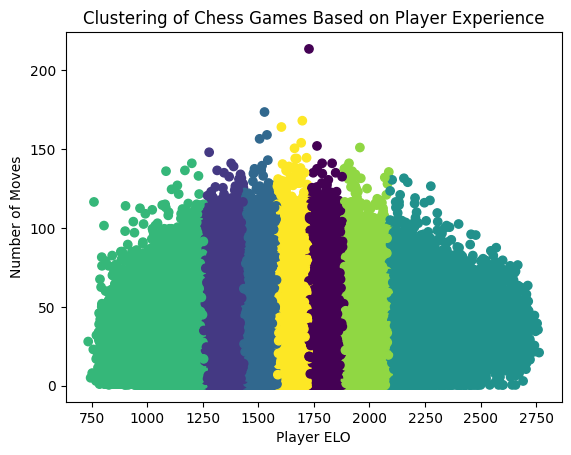

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Example data: [player_elo, num_moves, result]
# chess_data = np.array([
#     [1200, 45, 1],
#     [1300, 30, 0],
#     [1250, 50, 1],
#     [1400, 20, 0],
#     [1500, 60, 1],
#     [1600, 40, 1],
#     [1350, 55, 0]
# ])

# Number of clusters
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(chess_data)

# Assigning each game a cluster
print("Clusters:", clusters)

# Evaluating the clustering
# silhouette_avg = silhouette_score(chess_data, clusters)
# print("Silhouette Score:", silhouette_avg)

# Visualize the clustering
plt.scatter(chess_data[:, 0], chess_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Player ELO')
plt.ylabel('Number of Moves')
plt.title('Clustering of Chess Games Based on Player Experience')
plt.show()



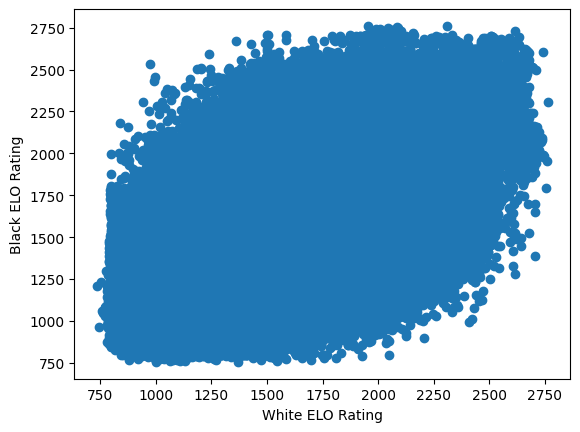

In [ ]:
import matplotlib.pyplot as plt

# Load in all the chess games
PGN_GAMES = r"datafiles/lichess_db_standard_rated_2015-08_condensed.pgn"
UCI_GAMES = r"datafiles/lichess_db_standard_rated_2015-08_condensed_uci.pgn"

pgn_documents = []
uci_documents = []
white_elo_ratings = []
results = []

# These are of the form:
# - Result
# - WhiteElo
# - BlackElo
# - Moves
# - [blank line]
games = open(PGN_GAMES)
all_lines = games.readlines()
pgn_documents = all_lines[3::5]
# Since these games are all the same except the move definition, it's safe to do this here
results = all_lines[0::5]
white_elo_ratings = all_lines[1::5]
black_elo_ratings = all_lines[2::5]
games.close()

games = open(UCI_GAMES)
uci_documents = games.readlines()[3::5]
games.close()

# x = [int(elo[len('[WhiteElo "'):-3]) for elo in white_elo_ratings]
# y = [int(elo[len('[BlackElo "'):-3]) for elo in black_elo_ratings]

# plt.scatter(x, y)
# plt.xlabel("White ELO Rating")
# plt.ylabel("Black ELO Rating")
# plt.show()

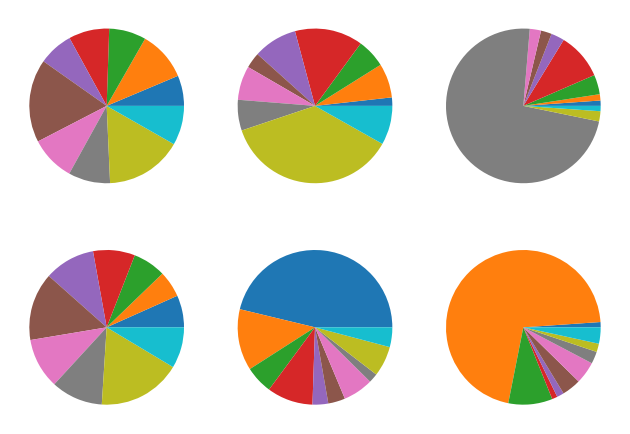

In [ ]:
# Clustering of chess based on moves
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter

# Group ELO ratings into groups of this size
# e.g. 500 would give 0-499, 500-999, 1000-1499, etc.
RESOLUTION = 250
def extract_grouped_elos(ratings, to_labels = False):
    new_ratings = [int(rating[len('[WhiteElo "'):-3]) for rating in ratings]
    new_ratings = [int(RESOLUTION * np.floor_divide(rating, RESOLUTION)) for rating in new_ratings]
    if to_labels:
        new_ratings = [int(rating / RESOLUTION) for rating in new_ratings]
        minimum = min(new_ratings)
        new_ratings = list(map(lambda x: x - minimum, new_ratings))
    return new_ratings

# Unlabeled clustering
elo_labels = extract_grouped_elos(white_elo_ratings, True)
k = len(set(elo_labels))

fig, axs = plt.subplots(nrows=2, ncols=3)

row = -1
# Test both PGN format and UCI format
for doc_set in [pgn_documents, uci_documents]:
    column = -1
    row += 1

    # Unigrams vs bigrams vs trigrams
    for n in [1, 2, 3]:
        column += 1
        vectorizer = TfidfVectorizer(ngram_range=(n, n))
        X = vectorizer.fit_transform(doc_set)
        predicted_labels = KMeans(n_clusters=k, random_state=42).fit_predict(X)

        ctr = Counter(predicted_labels)
        items_in_order = sorted(ctr.items(), key=lambda x: x[0])
        axs[row][column].pie(list(map(lambda x: x[1], items_in_order)))
plt.tight_layout()
plt.show()